# Защита персональных данных клиентов
## Описание проекта
Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.
Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.
## Цель исследования:
Разработка модели анонимизации персональных данных. Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.
## Описание данных
- Пол
- Возраст
- Зарплата
- Члены семьи
- Страховые выплаты

## Загрузка библиотек

In [1]:
!pip uninstall pandas-profiling

In [2]:
!pip install -q pandas-profiling[notebook,html]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.0/353.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np
import phik

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Другое
pd.options.display.expand_frame_repr = False
import warnings
warnings.filterwarnings('ignore')

# Загрузка файлов с диска
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

<ipython-input-3-78e195056fe8>:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Mounted at /content/drive


## Загрузка и изучение данных

In [4]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/datasets/7_insurance.csv')
df.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
df.tail()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0
4999,1,28.0,40600.0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


> 1. Датафрейм содержит 4 признака и 1 целевой признак (страховые выплаты клиенту за последние 5 лет).
> 2. Все признаки — количественные.
> 3. Пропуски в данных отсутствуют.

## Предобработка данных

In [7]:
# Для удобства переименуем столбцы
df.rename(columns={'Пол': 'sex', 'Возраст': 'age', 'Зарплата': 'salary', 'Члены семьи': 'family_members',
                     'Страховые выплаты': 'insurance_benefits'}, inplace=True)
df.sample()

,sex,age,salary,family_members,insurance_benefits
3303,0,25.0,52800.0,2,0


Изменим тип данных с float на int для признаков *age и salary*.  Но прежде чем менять формат столбца *salary* на всякий случай нужно убедиться, не потеряем ли мы от такого перехода какой-то информации, необходимой для обучения (что если, например, у некоторых наблюдений зарплата указана в тысячах). Проверить это мы можем, изучив дробную часть этого признака. Получить ее можно как остаток от деления на 1 (3.45 % 1 = 0.45). Таким образом мы можем определить дробную часть сразу для всего вектора значений. После этого посмотрим максимальное и минимальное значение дробной части, или вывести все отличные от нуля значения, посчитать их количество.

In [8]:
# Определим дробную часть для всего вектора значений признака
a = df['salary'] % 1
a.describe()

count    5000.00000
mean        0.00060
std         0.02449
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         1.00000
Name: salary, dtype: float64

In [9]:
a.unique()

array([0.00000000e+00, 3.63797881e-12, 7.27595761e-12, 1.00000000e+00])

> Размер зарплаты указан в целой цасти, значит дробную можно откинуть, изменив тип данных.

In [10]:
# Для признаков age и salary заменим тип данных на int
to_int = ['age', 'salary']
df[to_int] = df[to_int].astype('int')
df.dtypes

sex                   int64
age                   int64
salary                int64
family_members        int64
insurance_benefits    int64
dtype: object

В данном проекте немного спорный момент с дубликатами: так как у нас нет однозначного идентификатора клиента типа id, ФИО или чего-то подобного, то мы не можем со 100% уверенностью говорить, являются совпадения дубликатами или нет. Но все-таки предлагаю дубликаты убрать из данных.

In [11]:
# Проверим данные на дубликаты
df.duplicated().value_counts()

False    4847
True      153
dtype: int64

In [12]:
# Удалим дубликаты
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

## Исследование данных

In [13]:
df.describe()

,sex,age,salary,family_members,insurance_benefits
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811223,1.203425,0.152259
std,0.500049,8.487995,9972.952441,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


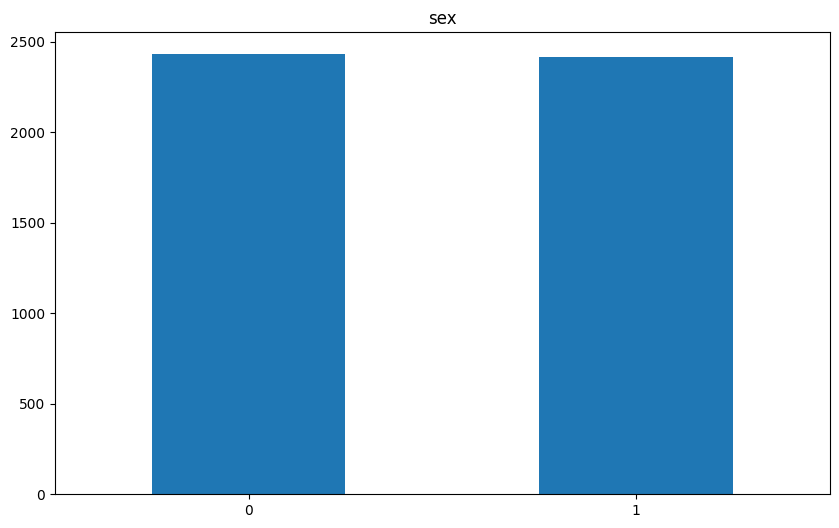

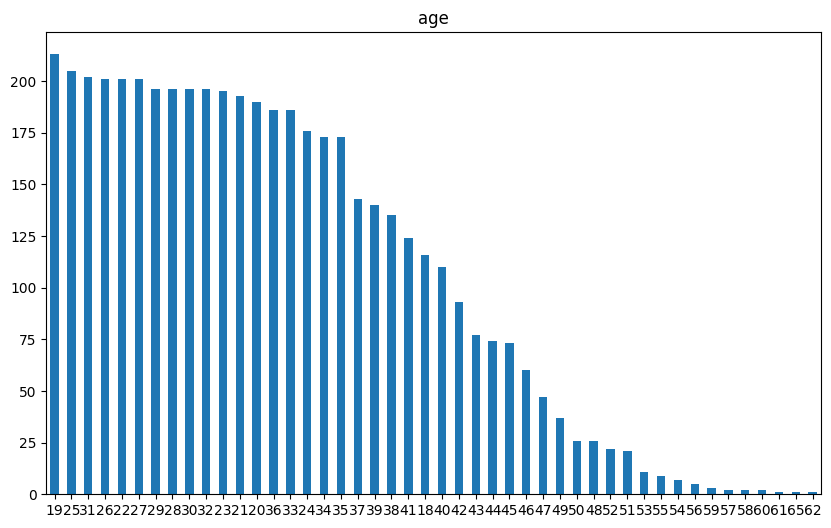

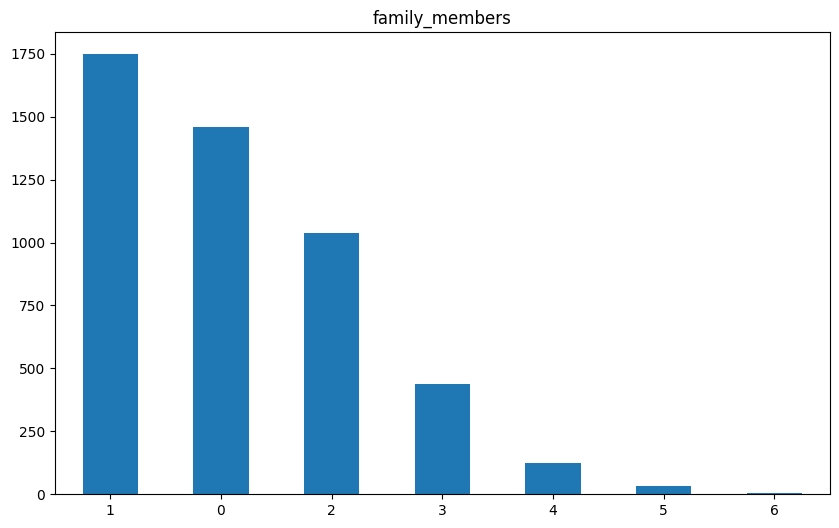

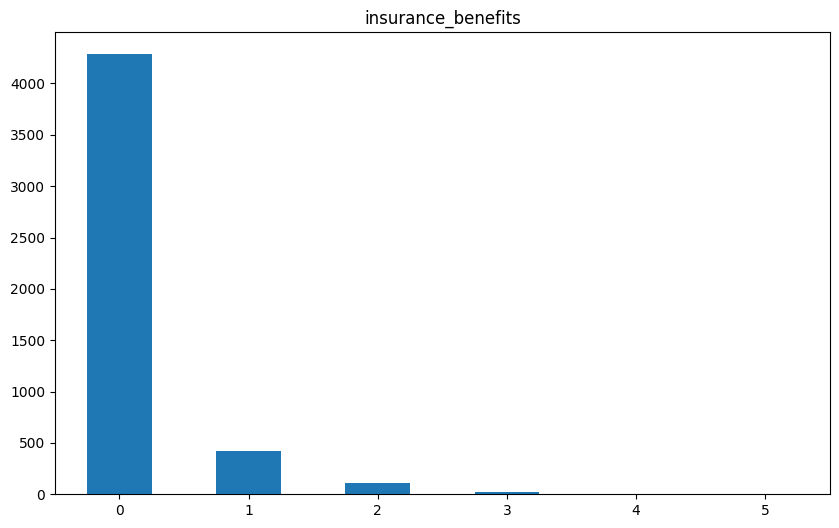

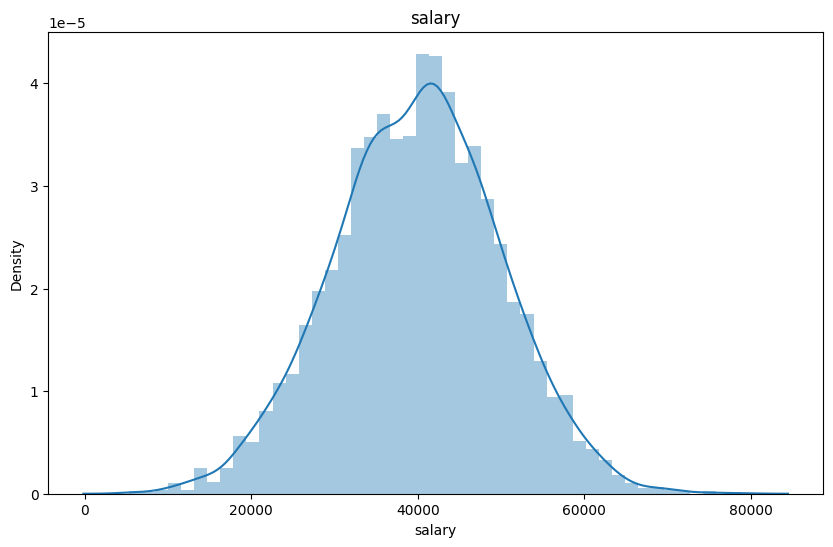

In [14]:
countplot = ['sex', 'age', 'family_members', 'insurance_benefits']
displot = ['salary']

for col in countplot:
    values = df[col].value_counts()
    plt.figure(figsize=(10,6))
    values.plot(kind = 'bar')
    plt.xticks(rotation=0)
    plt.title(col)

for col in displot:
    plt.figure(figsize=(10,6))
    sns.distplot(df[col])
    plt.title(col)

> 1. Количество женщин и мужчин среди клиентов почти одинаковое.
> 2. Чаще всего в страховую компанию обращаются люди в возрасте от 19 до ~ 42 года.
> 3. Чаще всего клиенты имеют 1 член семьи, реже - 3 и больше.
> 4. Наибольшая часть клиентов (~88%) за последние 5 лет не получали страховые выплаты. ~8% клиентов получили выплату один раз.
> 5. Из графика распределение зарплаты видим, что большинство значений приходится на диапазон от 35 до 45 тысяч руб. в месяц.

In [15]:
# Посмотрим на корреляцию между признаками
correlation_map = df.corr()
correlation_map

,sex,age,salary,family_members,insurance_benefits
sex,1.000000,0.001953,0.015456,-0.007315,0.011565
age,0.001953,1.000000,-0.017386,-0.009064,0.654964
salary,0.015456,-0.017386,1.000000,-0.031687,-0.013123
family_members,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
insurance_benefits,0.011565,0.654964,-0.013123,-0.039303,1.000000


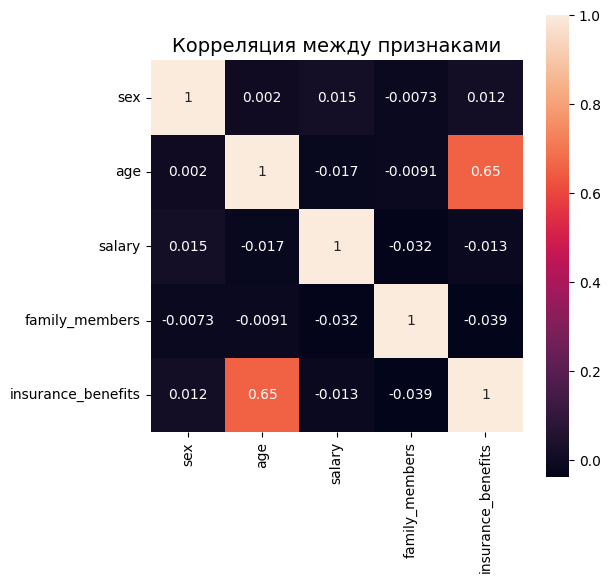

In [16]:
plt.figure(figsize = (6,6))
plt.title('Корреляция между признаками', size=14)
sns.heatmap(correlation_map, annot = True, square=True);

> Отметим, что есть корреляция между признаком age и целевым признаком insurance_benefits (коэффициент корреляции = 0.65).

In [17]:
# Посмотрим на Phik корреляцию:
df.phik_matrix()

interval columns not set, guessing: ['sex', 'age', 'salary', 'family_members', 'insurance_benefits']


,sex,age,salary,family_members,insurance_benefits
sex,1.000000,0.000000,0.000000,0.0,0.035338
age,0.000000,1.000000,0.065398,0.0,0.884910
salary,0.000000,0.065398,1.000000,0.0,0.000000
family_members,0.000000,0.000000,0.000000,1.0,0.000000
insurance_benefits,0.035338,0.884910,0.000000,0.0,1.000000


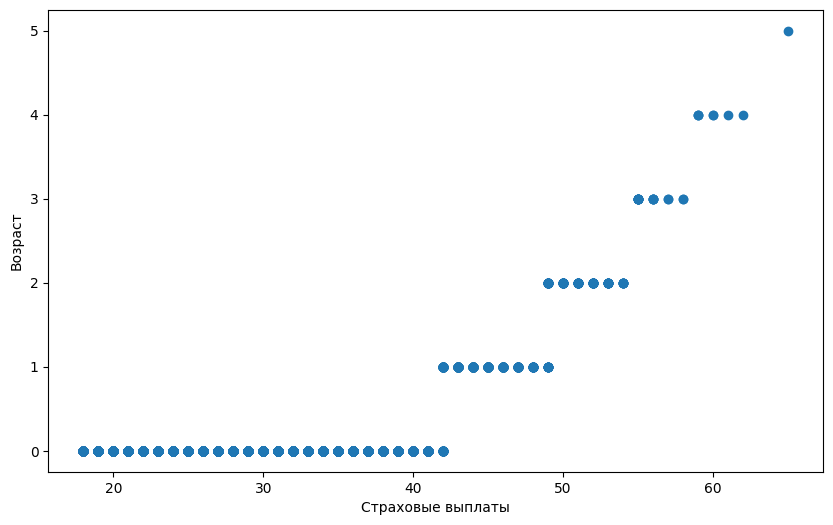

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = df['age'], y = df['insurance_benefits'])
plt.xlabel("Страховые выплаты")
plt.ylabel("Возраст")

plt.show()

> Если мы посмторим на даграмму рассеяния таргета и возраста, то действительно обнаружим, что зависимость скорре походит уже на какую-то квадратичную, значит, можно попробовать включить дополнительный признак - квадрат возраста.

In [19]:
profile = ProfileReport(df, title="Personal data")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Выводы:
1. На данном этапе проекта проверили данные на дубликаты.
2. Убедились, что данные не содержат пропуски.
3. Обработали данные: заменили тип данных для признаков age и salary, переименовали признаки.
4. Подробно изучив каждый признак, выяснили что: количество женщин и мужчин среди клиентов страховой компании почти одинаковая; чаще всего в страховую компанию обращаются люди в возрасте от 19 до ~42 года; чаще всего клиенты имеют 1 член семьи, реже - 3 и больше; чаще всего клиенты страховой компании зарабатывают от 35 до 45 тысяч руб. в месяц; 88% клиентов за последние 5 лет не получали страховые выплаты.

## Умножение матриц

**Задача: Ответьте на вопрос и обоснуйте решение. Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)**

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** Получается, что, если любую матрицу умножить на единичную (или наоборот), получится эта же матрица. Т.е., матрицы будут одинаковыми, а качество линейной регрессии не изменится.

**Обоснование:**
<p>Новая матрица признаков:</p>
$$X'=XP$$
<p>Новый вектор весов $w'$ можно рассчитать следующим образом:</p>
$$w' = ((XP)^T XP)^{-1} (XP)^T y == (P^TX^TXP)^{-1} P^TX^Ty == P^{-1}(X^TX)^{-1}(P^T)^{-1} P^TX^Ty == P^{-1}w$$
<p>внутри формулы можно выделить формулу расчета $w$, а</p>
$$(P^T)^{-1}P^T=E=1$$
<p>Таким образом предсказание:</p>
$$a'=X'w'=XPP^{-1}w=XEw=Xw=a$$

## Алгоритм преобразования

**Задача: Предложите алгоритм преобразования данных для решения задачи. Обоснуйте, почему качество линейной регрессии не поменяется.**

**Алгоритм:**
1. Методом make_spd_matrix создадим случайную матрицу A.
2. Методом np.linalg.inv() проверяем матрицу А на обратимость и получаем $А^{-1}$. Если матрица А провалила тест на обратимость (вероятность этого очень маленькая), необходимо создать новую случайную матрицу.
3. Поскольку нам надо закодировать данные клиентов, матрица А будет ключом кодирования: умножаем матрицу признаков X на полученную матрицу А и получаем матрицу B с закодированными данными о клиентах.
    $$B=X@A$$
4. После этого можно переходить к обучению модели линейной регрессии.

**Обоснование:** Такой алгоритм позволит защитить персональную информацию клиентов и при этом не должен повлиять на работу модели. Ранее мы уже отмечали, что качество модели не изменится, если матрицу признаков умножать на обратимую модель.

## Проверка алгоритма

### Преобразования данных

In [20]:
# Напишем функцию, которая преобразовывает данные:
def encode(df, randomstate=12345, randint=1000):
    try:
        # Задаём рандом
        rng = np.random.RandomState(randomstate)

        # Создаём матрицу, где идет разброс значений от 0 до 1000
        P = rng.randint(randint, size=(df.shape[1], df.shape[1]))

        # Проверяем обратимость. Если будет необратимая - перенесет на except
        Pinv = np.linalg.inv(P)

        # Преобразуем таблицу и снова задаём столбцы
        encoded_data = np.dot(df, P)
        encoded_data = pd.DataFrame(encoded_data, columns=df.columns)

        # Возвращаем ключ шифрования и преобразованную таблицу
        return encoded_data, Pinv
    except:
        print('Cannot create inverted matrix. Try another RandInt or RandomState.')

In [21]:
# Разделим датасет на признаки и целевой признак, проферим шифрацию данных:
features = df.drop('insurance_benefits', axis=1)
target = df['insurance_benefits']

features_encoded, encode_key = encode(features)
features_encoded

,sex,age,salary,family_members
0,27099671,26851825,38159001,5867671
1,20767689,20577865,29240226,4500527
2,11478180,11373325,16160078,2488353
3,22777758,22569255,32076630,4928307
4,14262842,14132485,20081881,3089925
...,...,...,...,...
4842,19504698,19326230,27465304,4222806
4843,28625049,28363165,40309242,6195443
4844,18518538,18349030,26078048,4007550
4845,17865029,17701480,25156951,3866898


### Обучение модели

In [22]:
# Разделим исходные данные на 2 выборки: обучающую и валидационную
features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                              target,
                                                                              train_size=0.75,
                                                                              test_size=0.25,
                                                                              random_state=12345)
# Выведем на экран размер выборок
print('features_train:', features_train.shape)
print('target_train:', target_train.shape)

print('')

print('features_valid:', features_valid.shape)
print('target_valid:', target_valid.shape)

features_train: (3635, 4)
target_train: (3635,)

features_valid: (1212, 4)
target_valid: (1212,)


In [23]:
# Обучим модель линейной регрессии и посчитаем метрику R2
model_raw = LinearRegression()
model_raw.fit(features_train, target_train)
predictions_raw = model_raw.predict(features_valid)
r2_raw = r2_score(target_valid, predictions_raw)

print('Метрика R2 до преобразования данных:', r2_raw)

Метрика R2 до преобразования данных: 0.4230772761583642


> **Метрика R2 не равно 0 и не больше 1, значит модель работает.**

In [25]:
# Разделим зашифрованные данные на 2 выборки: обучающую и валидационную
features_train_encoded, features_valid_encoded, target_train_encoded, target_valid_encoded = train_test_split(features_encoded,
                                                                                                              target,
                                                                                                              train_size=0.75,
                                                                                                              test_size=0.25,
                                                                                                              random_state=12345)

# Выведем на экран размер выборок
print('features_train_encoded:', features_train_encoded.shape)
print('target_train_encoded:', target_train_encoded.shape)

print('')

print('features_valid_encoded:', features_valid_encoded.shape)
print('target_valid_encoded:', target_valid_encoded.shape)

features_train_encoded: (3635, 4)
target_train_encoded: (3635,)

features_valid_encoded: (1212, 4)
target_valid_encoded: (1212,)


In [26]:
# Обучим модель линейной регрессии
model_encoded = LinearRegression()
model_encoded.fit(features_train_encoded, target_train_encoded)
predictions_encoded = model_encoded.predict(features_valid_encoded)

r2_encoded = r2_score(target_valid_encoded, predictions_encoded)
print('Метрика R2 после преобразования данных:', r2_encoded)

Метрика R2 после преобразования данных: 0.42307727615834934


In [27]:
# Сравним результат метрики R2 до и после преобразования данных.

print('Метрика R2 до преобразования данных:', r2_raw)
print('Метрика R2 после преобразования данных:', r2_encoded)

Метрика R2 до преобразования данных: 0.4230772761583642
Метрика R2 после преобразования данных: 0.42307727615834934


> Метрики почти идентичны, а это значит, что качество модели линейной регрессии после преобразования данных не изменилось. Но стотит отметить, что сам показатель метрики R2 достаточно низкий, значит, качество модели можно значительно улучшить, например, округлив предсказания, то значения метрик в данном случае оказываются лучше, так как таргет изначально дискретный и мы избавляемся от лишнего шума в предсказании.

### Алгоритм-дешифровщик
Создадим специальный алгоритм-дешифровщик и объединим его с алгоритмом-шифровщиком одним классом: шифровщик будет генерировать матрицу, проверять ее и сохранять внутри объекта, а дешифровщик сможет обращаться к ключу, хранящемуся внутри объекта, и использовать его для расшифровки.

In [28]:
class DataEncrypter:

    def __init__(self, random_state=12345, rand_int=1000):
        self.rand_int = rand_int
        self.rnd = np.random.RandomState(random_state)

        self.encrypted_data: pd.DataFrame
        self.key: np.array
        self.key_inv: np.array

    def encrypt(self, data: pd.DataFrame) -> None:
        try:
            self.key = self.rnd.randint(self.rand_int, size=(df.shape[1], df.shape[1]))
            self.key_inv = np.linalg.inv(self.key)
        except np.linalg.LinAlgError:
            print('Cannot create inverted matrix. Try another RandInt or RandomState')

        self.encrypted_data = pd.DataFrame(np.dot(df.values, self.key),
                                           columns=df.columns)
    def decrypt(self) -> pd.DataFrame:
        return self.encrypted_data.dot(self.key_inv)

## Вывод
**В ходе работы было проделано:**

1. Загружены и изучены данные.
2. Качество линейной регресии не изменилось от использования исодной матрици и исходной матрицы, умноженную на обратимую.
3. Создан алгоритм преобразования данных.
4. Исследован алгоритм преобразования данных и проверена метрика R2 для данных без преобразования и с ним.
5. По результатам работы использования матричных операций можно увидеть, что данные очень просто зашифровать от распознования, имея правильную матрицу.